In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
sb.set_style("whitegrid", {'axes.facecolor': '#EAEAF2'})

from scipy import stats
stats.chisqprob = lambda x2, dof: stats.chi2.sf(x2, dof)
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

from sklearn.preprocessing import StandardScaler as Scaler, LabelEncoder as Encoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as TreeModel
from sklearn.ensemble import RandomForestClassifier , VotingClassifier as Vote, AdaBoostClassifier as AdaBoost, GradientBoostingRegressor as GBReg, BaggingClassifier as Bagging
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV , StratifiedKFold
from imblearn.over_sampling import SMOTE , RandomOverSampler
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , mean_squared_error as mse, roc_auc_score as auc, precision_score , recall_score , f1_score
from sklearn.datasets import make_classification as make_data
from xgboost import XGBClassifier as XGB


### - Data overview

In [66]:
df = pd.read_csv("/content/heart_disease.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319794 entries, 0 to 319793
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319794 non-null  object 
 1   BMI               319794 non-null  float64
 2   Smoking           319794 non-null  object 
 3   AlcoholDrinking   319794 non-null  object 
 4   Stroke            319794 non-null  object 
 5   PhysicalHealth    319794 non-null  int64  
 6   MentalHealth      319794 non-null  int64  
 7   DiffWalking       319794 non-null  object 
 8   Sex               319794 non-null  object 
 9   AgeCategory       319794 non-null  object 
 10  Race              319794 non-null  object 
 11  Diabetic          319794 non-null  object 
 12  PhysicalActivity  319794 non-null  object 
 13  GenHealth         319794 non-null  object 
 14  SleepTime         319794 non-null  int64  
 15  Asthma            319794 non-null  object 
 16  KidneyDisease     31

In [68]:
df.shape

(319794, 18)

## Data Cleaning & Preprocessing

In [69]:
df.isnull().sum()

,0
HeartDisease,0
BMI,0
Smoking,0
AlcoholDrinking,0
Stroke,0
PhysicalHealth,0
MentalHealth,0
DiffWalking,0
Sex,0
AgeCategory,0


In [70]:
print(f"Total duplicate entries found: {df.duplicated().sum()}")

Total duplicate entries found: 18078


In [71]:
df.drop_duplicates(inplace=True)
print(f"The number of duplicated values is : {df.duplicated().sum()}")

The number of duplicated values is : 0


In [72]:
df.drop(columns=['SkinCancer', 'Race'], inplace=True)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,Yes,Yes,Very good,5,Yes,No
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,No,Yes,Very good,7,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,Yes,Yes,Fair,8,Yes,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,No,No,Good,6,No,No
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,No,Yes,Very good,8,No,No


### - Handle Outliers

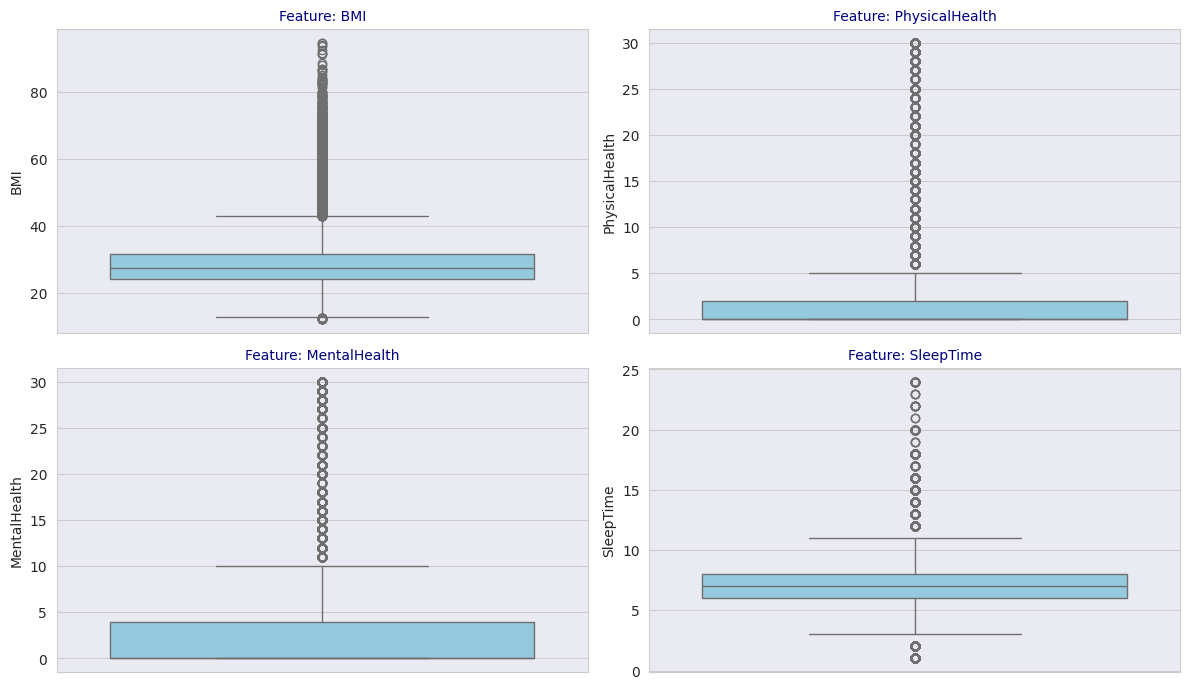

In [73]:
num_data = df.select_dtypes(include=['number'])
num_features = num_data.columns
feature_count = len(num_data.columns)
cols_per_row = 2
rows_needed = 2

fig, axs = plt.subplots(rows_needed, cols_per_row, figsize=(12, 7))
axs = axs.flatten()

for idx, feature in enumerate(num_features):
    sb.boxplot(y=df[feature], ax=axs[idx], color="skyblue")
    axs[idx].set_title(f"Feature: {feature}", fontsize=10, color='navy')

plt.tight_layout()
plt.show()


In [74]:
# realistic BMI range: 10–60 kg/m²
df = df[(df["BMI"] >= 10) & (df["BMI"] <= 60)]

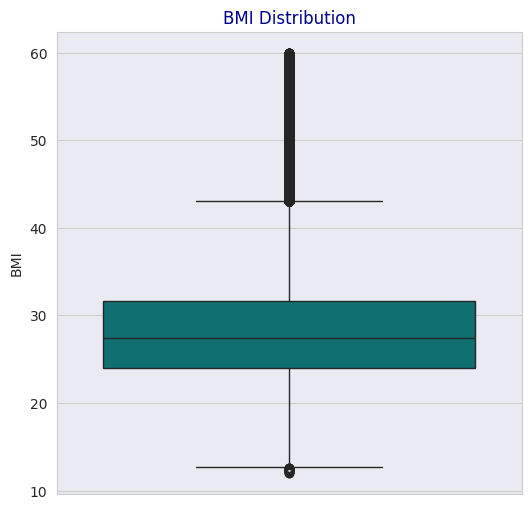

In [75]:
plt.figure(figsize=(6, 6))
sb.boxplot(y=df["BMI"], color="teal")
plt.title("BMI Distribution", fontsize=12, color='darkblue')
plt.show()

In [76]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the column
Q1 = df["SleepTime"].quantile(0.25)
Q3 = df["SleepTime"].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df = df[(df["SleepTime"] >= lower_bound) & (df["SleepTime"] <= upper_bound)]

Text(0.5, 1.0, 'Sleep time')

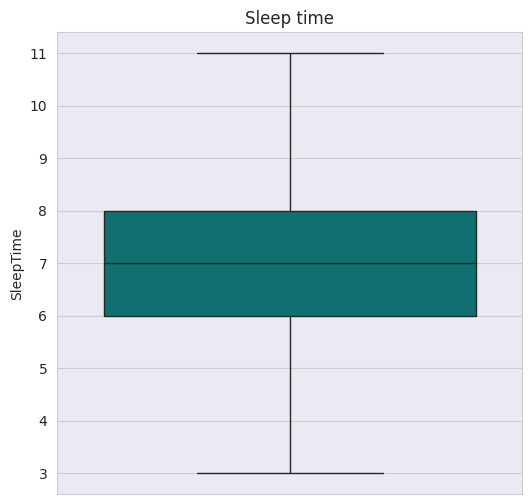

In [77]:
plt.figure(figsize=(6 , 6))
sb.boxplot(y=df["SleepTime"], color = "teal")
plt.title("Sleep time")

In [90]:
df_preproccesed = df.copy()

In [91]:
df_preproccesed["Sex"].unique()

array(['Female', 'Male'], dtype=object)

In [92]:
# Define an ordered mapping
Sex_mapping = {
    'Female': 0,
    'Male': 1,
}
# Apply mapping
df_preproccesed['Sex'] = df_preproccesed['Sex'].map(Sex_mapping)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,Yes,Yes,Very good,5,Yes,No
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,No,Yes,Very good,7,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,Yes,Yes,Fair,8,Yes,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,No,No,Good,6,No,No
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,No,Yes,Very good,8,No,No


In [93]:
df_preproccesed["GenHealth"].unique()

array(['Very good', 'Fair', 'Good', 'Excellent', 'Poor'], dtype=object)

In [94]:
# Define an ordered mapping
GenHealth_mapping = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
}

# Apply mapping
df_preproccesed['GenHealth'] = df_preproccesed['GenHealth'].map(GenHealth_mapping)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,Yes,Yes,Very good,5,Yes,No
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,No,Yes,Very good,7,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,Yes,Yes,Fair,8,Yes,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,No,No,Good,6,No,No
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,No,Yes,Very good,8,No,No


In [95]:
df_preproccesed["AgeCategory"].unique()

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

In [96]:
# Define an ordered mapping
age_mapping = {
    '18-24': 1, '25-29': 2, '30-34': 3, '35-39': 4, '40-44': 5,
    '45-49': 6, '50-54': 7, '55-59': 8, '60-64': 9, '65-69': 10,
    '70-74': 11, '75-79': 12, '80 or older': 13
}

# Apply mapping
df_preproccesed['AgeCategory'] = df_preproccesed['AgeCategory'].map(age_mapping)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,Yes,Yes,Very good,5,Yes,No
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,No,Yes,Very good,7,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,Yes,Yes,Fair,8,Yes,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,No,No,Good,6,No,No
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,No,Yes,Very good,8,No,No


In [97]:
df["Diabetic"].value_counts()

,count
Diabetic,
No,248197
Yes,39328
"No, borderline diabetes",6650
Yes (during pregnancy),2530


In [98]:
# Define an ordered mapping
binary_mapping = {
    'Yes': 1,
    'No': 0,
    'No, borderline diabetes': 0.5,
    'Yes (during pregnancy)': 1
}

# Apply mapping
binary_df = df_preproccesed.select_dtypes(include=['object'])

for col in binary_df.columns:
    df_preproccesed[col] = df_preproccesed[col].map(binary_mapping)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,Yes,Yes,Very good,5,Yes,No
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,No,Yes,Very good,7,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,Yes,Yes,Fair,8,Yes,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,No,No,Good,6,No,No
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,No,Yes,Very good,8,No,No


### Standardization

In [99]:
numerical_cols = (df_preproccesed.select_dtypes(include=['number'])).columns
processed_data = (df_preproccesed[numerical_cols] - df_preproccesed[numerical_cols].min()) / (df_preproccesed[numerical_cols].max() - df_preproccesed[numerical_cols].min())
processed_data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,0.0,0.095516,1.0,0.0,0.0,0.100000,1.0,0.0,0.0,0.583333,1.0,1.0,0.75,0.250,1.0,0.0
1,0.0,0.173514,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.0,1.0,0.75,0.500,0.0,0.0
2,0.0,0.303650,1.0,0.0,0.0,0.666667,1.0,0.0,1.0,0.750000,1.0,1.0,0.25,0.625,1.0,0.0
3,0.0,0.254223,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.916667,0.0,0.0,0.50,0.375,0.0,0.0
4,0.0,0.243796,0.0,0.0,0.0,0.933333,0.0,1.0,0.0,0.333333,0.0,1.0,0.75,0.625,0.0,0.0


## Exploratory Data Analysis

In [100]:
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f']  # define new color palette

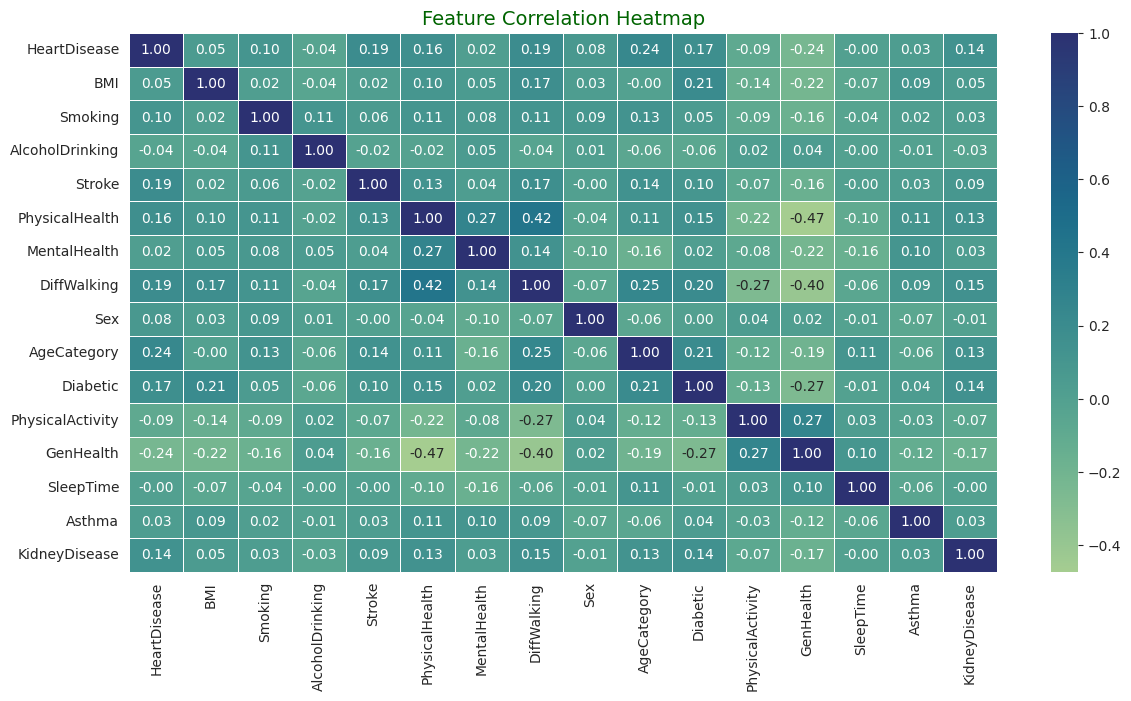

In [101]:
correlation_mat = processed_data.corr()

plt.figure(figsize=(14, 7))
sb.heatmap(correlation_mat, annot=True, cmap="crest", fmt=".2f", linewidths=0.7, linecolor='white')

plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.title("Feature Correlation Heatmap", fontsize=14, color='darkgreen')
plt.show()


###  BMI distribution

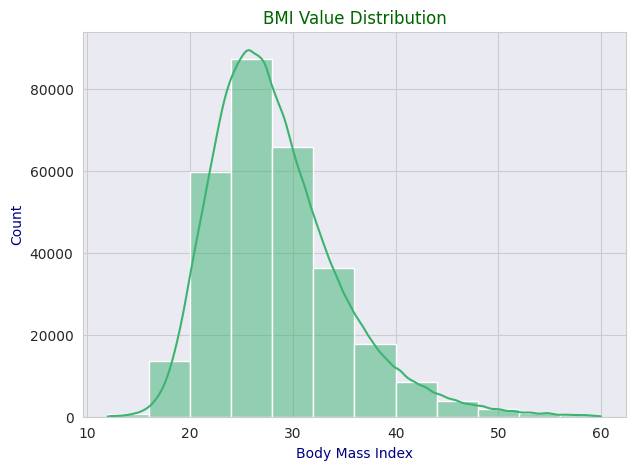

In [102]:
plt.figure(figsize=(7, 5))
sb.histplot(df["BMI"], bins=12, kde=True, color="mediumseagreen")

# Labels and title
plt.xlabel("Body Mass Index", fontsize=10, color='navy')
plt.ylabel("Count", fontsize=10, color='navy')
plt.title("BMI Value Distribution", fontsize=12, color='darkgreen')

plt.savefig("BMI_histogram.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()


### Age category VS BMI

<ipython-input-103-e06850e6a671>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x="AgeCategory", y="BMI",


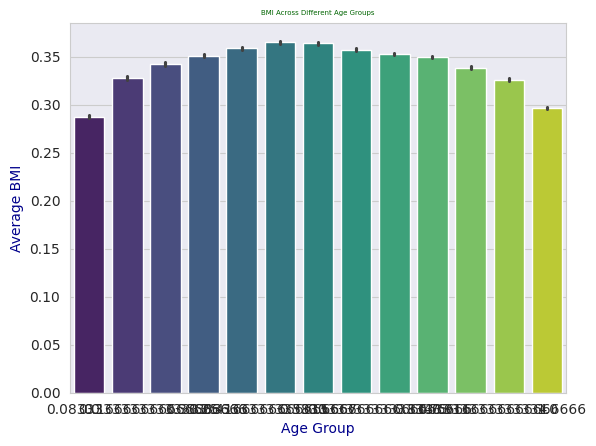

In [103]:
sb.barplot(x="AgeCategory", y="BMI",
           data=processed_data, palette="viridis")

plt.xlabel("Age Group", fontsize=10, color='darkblue')
plt.ylabel("Average BMI", fontsize=10, color='darkblue')
plt.title("BMI Across Different Age Groups", fontsize=5, color='darkgreen')

plt.savefig("BMI_vs_AgeGroup.png", dpi=300, bbox_inches='tight')
plt.show()

###  Sex VS Heart disease

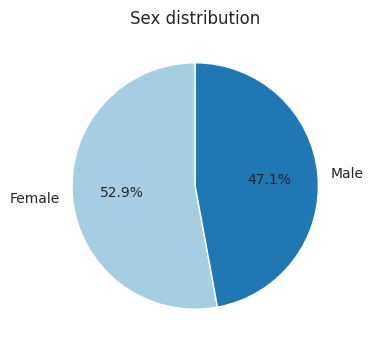

In [104]:
# Sex Distribution
Sex_distribution = df["Sex"].value_counts()
plt.figure(figsize=(4 , 4))
plt.pie(Sex_distribution.values , labels = Sex_distribution.index , autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Sex distribution")
plt.savefig("SEX_dist.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-105-10781dad51b2>:10: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  barplot = sb.barplot(x="HeartDisease", y="Count", hue="Sex", data=Sex_counts, palette=colors)


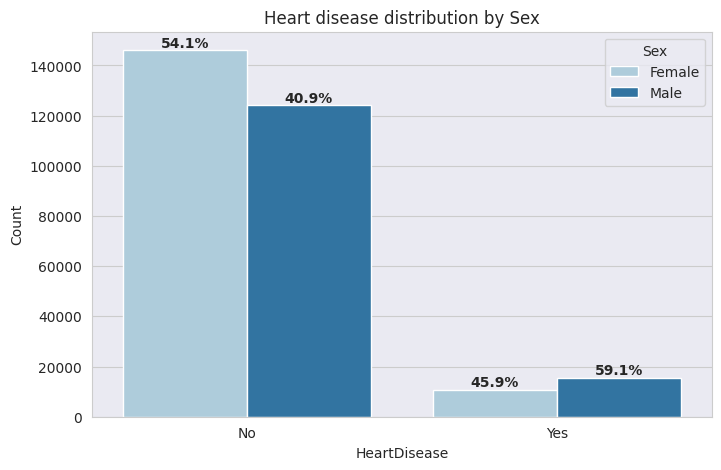

In [105]:
# Sex VS HeartDisease
Sex_counts = df.groupby(["HeartDisease", "Sex"]).size().reset_index(name="Count")

# Calculate total count per HeartDisease category for percentage calculation
total_per_heart = Sex_counts.groupby("HeartDisease")["Count"].transform("sum")
Sex_counts["Percent"] = (Sex_counts["Count"] / total_per_heart) * 100

# Plot grouped bar chart using seaborn
plt.figure(figsize=(8, 5))
barplot = sb.barplot(x="HeartDisease", y="Count", hue="Sex", data=Sex_counts, palette=colors)

# Add percentage labels on top of each bar
for i in range(len(Sex_counts)):
    row = Sex_counts.iloc[i]
    bar = barplot.patches[i]
    height = bar.get_height()
    barplot.text(bar.get_x() + bar.get_width() / 2,height + 0.5,f'{row["Percent"]:.1f}%',ha='center',va='bottom',fontsize=10, fontweight='bold')

# Labels and formatting
plt.xlabel("HeartDisease")
plt.ylabel("Count")
plt.title("Heart disease distribution by Sex")
plt.legend(title="Sex")
plt.savefig("SEX.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

### Age category VS Heart disease

In [106]:
# Define an ordered mapping
age_mapping = {
    '18-24': 'Young-Adult', '25-29': 'Young-Adult', '30-34': 'Young-Adult', '35-39': 'Young-Adult',
    '40-44': 'Middle-Adult', '45-49': 'Middle-Adult', '50-54': 'Middle-Adult',
    '55-59': 'Middle-Adult', '60-64': 'Old-Adult', '65-69': 'Old-Adult',
    '70-74': 'Old-Adult', '75-79': 'Elderly', '80 or older': 'Elderly'
}

# Apply mapping
df['AgeCategory'] = df['AgeCategory'].map(age_mapping)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,No,16.60,Yes,No,No,3,30,No,Female,Middle-Adult,Yes,Yes,Very good,5,Yes,No
1,No,20.34,No,No,Yes,0,0,No,Female,Elderly,No,Yes,Very good,7,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,Old-Adult,Yes,Yes,Fair,8,Yes,No
3,No,24.21,No,No,No,0,0,No,Female,Elderly,No,No,Good,6,No,No
4,No,23.71,No,No,No,28,0,Yes,Female,Middle-Adult,No,Yes,Very good,8,No,No


<ipython-input-107-7e52df85f354>:13: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sb.barplot(x="HeartDisease", y="Count", hue="AgeCategory",hue_order = hue_order, data=AgeCategory_counts, palette=colors)


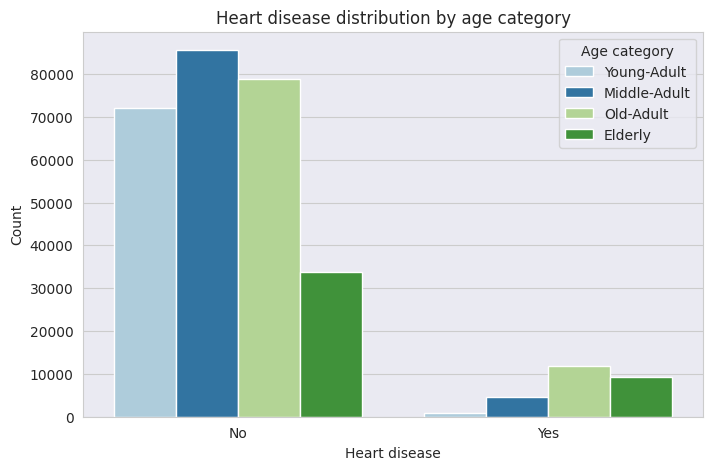

In [107]:
AgeCategory_counts = df.groupby(["HeartDisease", "AgeCategory"]).size().reset_index(name="Count")

age_colors = {
    "Young-Adult": colors[0],
    "Middle-Adult": colors[1],
    "Old-Adult": colors[2],
    "Elderly": colors[3]
}

hue_order = list(age_colors.keys())

plt.figure(figsize=(8, 5))
sb.barplot(x="HeartDisease", y="Count", hue="AgeCategory",hue_order = hue_order, data=AgeCategory_counts, palette=colors)

# Labels and formatting
plt.xlabel("Heart disease")
plt.ylabel("Count")
plt.title("Heart disease distribution by age category")
plt.legend(title="Age category")
plt.savefig("Age Category.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

###Alcohol drinking VS Heart disease

<ipython-input-108-af8f53fcefbe>:8: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="AlcoholDrinking", data=AlcoholDrinking_counts, palette=colors)


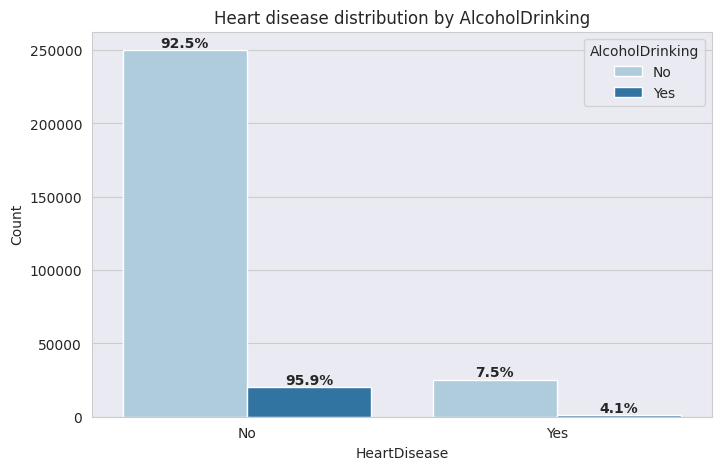

In [108]:
AlcoholDrinking_counts = df.groupby(["HeartDisease", "AlcoholDrinking"]).size().reset_index(name="Count")

# Calculate total count per HeartDisease category for percentage calculation
total_per_heart = AlcoholDrinking_counts.groupby("HeartDisease")["Count"].transform("sum")
AlcoholDrinking_counts["Percent"] = (AlcoholDrinking_counts["Count"] / total_per_heart) * 100

plt.figure(figsize=(8, 5))
barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="AlcoholDrinking", data=AlcoholDrinking_counts, palette=colors)

# Add percentage labels on top of each bar
for i in range(len(AlcoholDrinking_counts)):
    row = AlcoholDrinking_counts.iloc[i]
    bar = barplot.patches[i]
    height = bar.get_height()
    barplot.text(bar.get_x() + bar.get_width() / 2,height + 0.5,f'{row["Percent"]:.1f}%',ha='center',va='bottom',fontsize=10, fontweight='bold')

# Labels and formatting
plt.xlabel("HeartDisease")
plt.ylabel("Count")
plt.title("Heart disease distribution by AlcoholDrinking")
plt.legend(title="AlcoholDrinking")
plt.savefig("Alcohol.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

###  Smoking VS Heart disease

<ipython-input-109-0ca4b839cd79>:8: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  barplot =sb.barplot(x="HeartDisease", y="Count", hue="Smoking", data=smoking_counts, palette=colors)


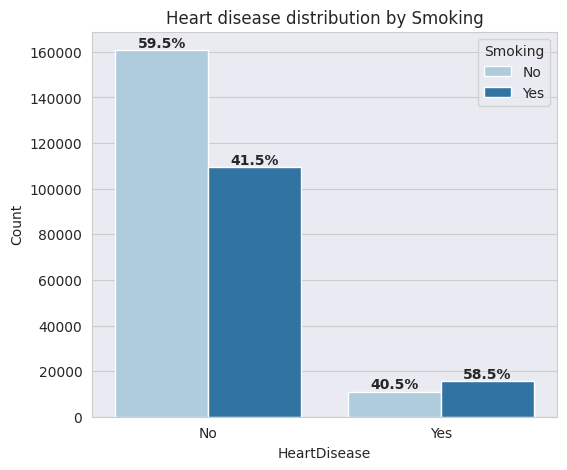

In [109]:
smoking_counts = df.groupby(["HeartDisease", "Smoking"]).size().reset_index(name="Count")

# Calculate total count per HeartDisease category for percentage calculation
total_per_heart = smoking_counts.groupby("HeartDisease")["Count"].transform("sum")
smoking_counts["Percent"] = (smoking_counts["Count"] / total_per_heart) * 100

plt.figure(figsize=(6, 5))
barplot =sb.barplot(x="HeartDisease", y="Count", hue="Smoking", data=smoking_counts, palette=colors)

# Add percentage labels on top of each bar
for i in range(len(smoking_counts)):
    row = smoking_counts.iloc[i]
    bar = barplot.patches[i]
    height = bar.get_height()
    barplot.text(bar.get_x() + bar.get_width() / 2,height + 0.5,f'{row["Percent"]:.1f}%',ha='center',va='bottom',fontsize=10, fontweight='bold')
# Labels and formatting
plt.xlabel("HeartDisease")
plt.ylabel("Count")
plt.title("Heart disease distribution by Smoking")
plt.legend(title="Smoking")
plt.savefig("Smoking.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

###Diabetic VS Heart disease

In [110]:
df["Diabetic"].value_counts()


,count
Diabetic,
No,248197
Yes,39328
"No, borderline diabetes",6650
Yes (during pregnancy),2530


In [111]:
df = df[(df["Diabetic"] == "Yes") | (df["Diabetic"] == "No")]

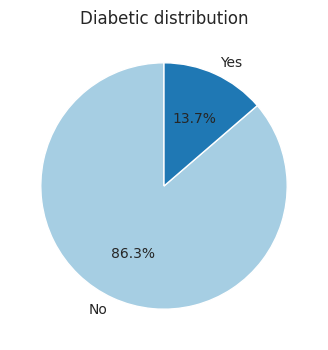

In [112]:
# Diabetic Distribution
Diabetic_distribution = df["Diabetic"].value_counts()
plt.figure(figsize=(4 , 4))
plt.pie(Diabetic_distribution.values , labels = Diabetic_distribution.index , autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Diabetic distribution")
plt.savefig("Diabetic_dist.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-113-e06cd5848133>:8: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="Diabetic", data=Diabetic_counts, palette=colors)


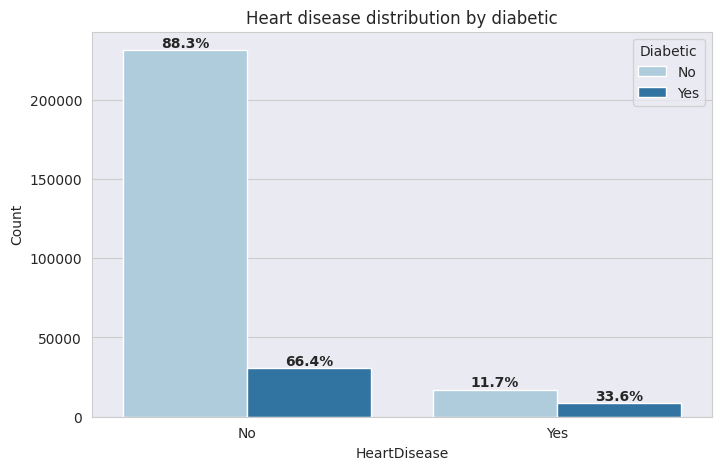

In [113]:
Diabetic_counts = pd.DataFrame(df.groupby(["HeartDisease", "Diabetic"]).size().reset_index(name="Count"))

# Calculate total count per HeartDisease category for percentage calculation
total_per_heart = Diabetic_counts.groupby("HeartDisease")["Count"].transform("sum")
Diabetic_counts["Percent"] = (Diabetic_counts["Count"] / total_per_heart) * 100

plt.figure(figsize=(8, 5))
barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="Diabetic", data=Diabetic_counts, palette=colors)

# Add percentage labels on top of each bar
for i in range(len(Diabetic_counts)):
    row = Diabetic_counts.iloc[i]
    bar = barplot.patches[i]
    height = bar.get_height()
    barplot.text(bar.get_x() + bar.get_width() / 2,height + 0.5,f'{row["Percent"]:.1f}%',ha='center',va='bottom',fontsize=10, fontweight='bold')
# Labels and formatting
plt.xlabel("HeartDisease")
plt.ylabel("Count")
plt.title("Heart disease distribution by diabetic")
plt.legend(title="Diabetic")
plt.savefig("Diabetic.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

### Stroke VS Heart disease

<ipython-input-114-1aed1fba5d6d>:8: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="Stroke", data=Stroke_counts, palette=colors)


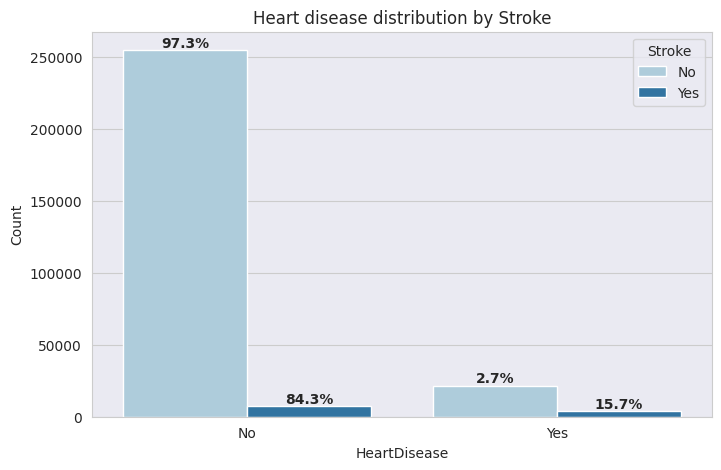

In [114]:
Stroke_counts = df.groupby(["HeartDisease", "Stroke"]).size().reset_index(name="Count")

# Calculate total count per HeartDisease category for percentage calculation
total_per_heart = Stroke_counts.groupby("HeartDisease")["Count"].transform("sum")
Stroke_counts["Percent"] = (Stroke_counts["Count"] / total_per_heart) * 100

plt.figure(figsize=(8, 5))
barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="Stroke", data=Stroke_counts, palette=colors)

# Add percentage labels on top of each bar
for i in range(len(Stroke_counts)):
    row = Stroke_counts.iloc[i]
    bar = barplot.patches[i]
    height = bar.get_height()
    barplot.text(bar.get_x() + bar.get_width() / 2,height + 0.5,f'{row["Percent"]:.1f}%',ha='center',va='bottom',fontsize=10, fontweight='bold')


# Labels and formatting
plt.xlabel("HeartDisease")
plt.ylabel("Count")
plt.title("Heart disease distribution by Stroke")
plt.legend(title="Stroke")
plt.savefig("Stroke.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

###General health VS Heart disease

In [115]:
df['GenHealth'].value_counts()

,count
GenHealth,
Very good,100849
Good,86527
Excellent,57907
Fair,32144
Poor,10098


<ipython-input-116-4a4815ecad4f>:20: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="GenHealth",hue_order = hue_order, data=GenHealth_counts, palette=colors)


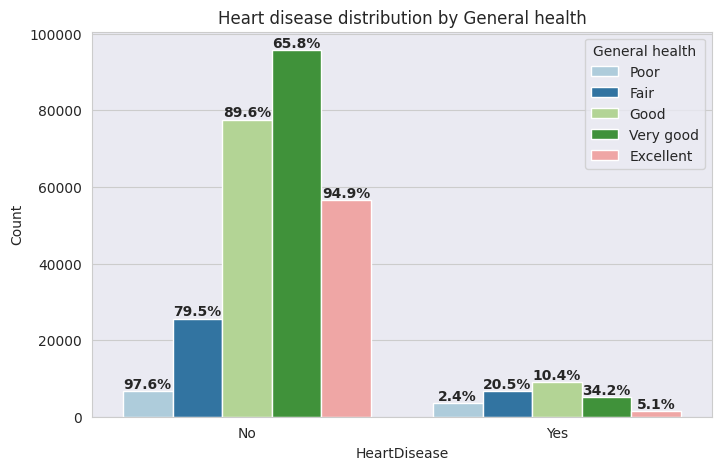

In [116]:
GenHealth_counts = df.groupby(["GenHealth", "HeartDisease"]).size().reset_index(name="Count")

GenHealth_colors = {
    "Poor": colors[0],
    "Fair": colors[1],
    "Good": colors[2],
    "Very good": colors[3],
    "Excellent": colors[4]
}
# Define the order of AgeCategory as per the colors dictionary
hue_order = list(GenHealth_colors.keys())

# Total per GenHealth group
total_per_health = GenHealth_counts.groupby("GenHealth")["Count"].transform("sum")

# Compute percentage within each GenHealth group
GenHealth_counts["Percent"] = (GenHealth_counts["Count"] / total_per_health) * 100

plt.figure(figsize=(8, 5))
barplot= bar_plot = sb.barplot(x="HeartDisease", y="Count", hue="GenHealth",hue_order = hue_order, data=GenHealth_counts, palette=colors)

# Add percentage labels on top of each bar
for i in range(len(GenHealth_counts)):
    row = GenHealth_counts.iloc[i]
    bar = barplot.patches[i]
    height = bar.get_height()
    barplot.text(bar.get_x() + bar.get_width() / 2,height + 0.5,f'{row["Percent"]:.1f}%',ha='center',va='bottom',fontsize=10, fontweight='bold')

# Labels and formatting
plt.xlabel("HeartDisease")
plt.ylabel("Count")
plt.title("Heart disease distribution by General health")
plt.legend(title="General health")
plt.savefig("General health.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

###Sleep quality VS Heart disease

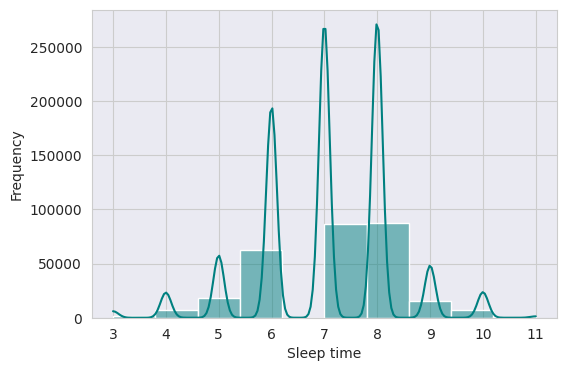

In [117]:
plt.figure(figsize=(6, 4))
sb.histplot(df["SleepTime"], bins = 10, kde=True ,  color = "teal")
# Labels and title
plt.xlabel("Sleep time")
plt.ylabel("Frequency")
plt.savefig("Sleep_dist.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

In [118]:
df['SleepTime_cat'] = pd.cut(df['SleepTime'],
                                bins=[0, 4, 6, 9, df['SleepTime'].max()],
                                labels=['Severely Sleep', 'Short Sleep', 'Normal Sleep', 'Long Sleep'])

<ipython-input-119-01f23973413c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  SleepTime_cat_counts = df.groupby(["HeartDisease", "SleepTime_cat"]).size().reset_index(name="Count")


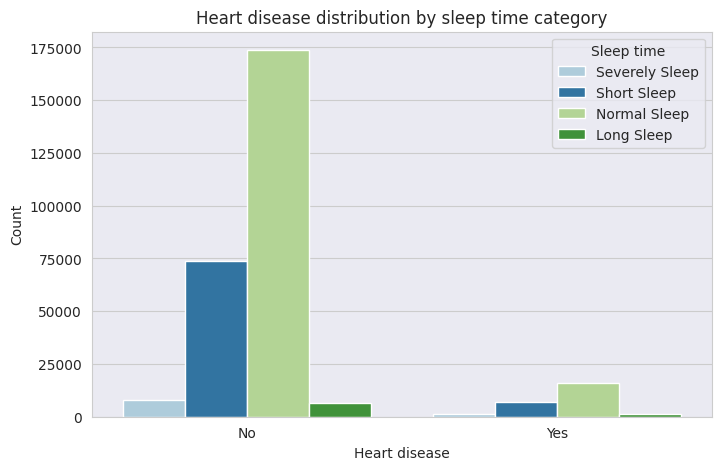

In [119]:
SleepTime_cat_counts = df.groupby(["HeartDisease", "SleepTime_cat"]).size().reset_index(name="Count")

# Plot grouped bar chart using seaborn
plt.figure(figsize=(8, 5))

SleepTime_cat_colors = {
    "Severely Sleep": colors[0],
    "Short Sleep": colors[1],
    "Normal Sleep": colors[2],
    "Long Sleep": colors[3]
}
# Define the order of AgeCategory as per the colors dictionary
hue_order = list(SleepTime_cat_colors.keys())

# Create the bar plot with sorted hues
sb.barplot(x="HeartDisease", y="Count", hue="SleepTime_cat",
            data=SleepTime_cat_counts, palette=SleepTime_cat_colors, hue_order=hue_order)

# Labels and formatting
plt.xlabel("Heart disease")
plt.ylabel("Count")
plt.title("Heart disease distribution by sleep time category")
plt.legend(title="Sleep time")
plt.savefig("Sleep.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

## Machine Learning

In [120]:
processed_data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease
0,0.0,0.095516,1.0,0.0,0.0,0.100000,1.0,0.0,0.0,0.583333,1.0,1.0,0.75,0.250,1.0,0.0
1,0.0,0.173514,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.000000,0.0,1.0,0.75,0.500,0.0,0.0
2,0.0,0.303650,1.0,0.0,0.0,0.666667,1.0,0.0,1.0,0.750000,1.0,1.0,0.25,0.625,1.0,0.0
3,0.0,0.254223,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.916667,0.0,0.0,0.50,0.375,0.0,0.0
4,0.0,0.243796,0.0,0.0,0.0,0.933333,0.0,1.0,0.0,0.333333,0.0,1.0,0.75,0.625,0.0,0.0


In [121]:
X = processed_data.iloc[:,1:]
y = processed_data.iloc[:,0]


In [122]:
SEED = 42  # or any integer seed for reproducibility
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify= y,random_state=42)

In [123]:
log_model = LogReg(random_state=SEED)

grid_params = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)

grid_search_log = GridSearchCV(estimator=log_model, param_grid=grid_params, scoring='f1', cv=kfold, n_jobs=-1)

grid_search_log.fit(train_X, train_y)


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='f1')

In [136]:
best_log_model = grid_search_log.best_estimator_

pred_test_log = best_log_model.predict(test_X)
pred_train_log = best_log_model.predict(train_X)
pred_proba_log = best_log_model.predict_proba(test_X)[:, 1]

conf_matrix_log = confusion_matrix(test_y, pred_test_log)
class_report_log = classification_report(test_y, pred_test_log)

best_score_log = grid_search_log.best_score_

accuracy_log_test = accuracy_score(test_y, pred_test_log)
accuracy_log_train = accuracy_score(train_y, pred_train_log)

rmse_log = mse(test_y, pred_test_log) ** 0.5

precision_log = precision_score(test_y, pred_test_log)
recall_log = recall_score(test_y, pred_test_log)
f1_log = f1_score(test_y, pred_test_log)

best_params_log = grid_search_log.best_params_


In [138]:
print('Model : Logistic Regression (Before Resampling)')
print("______________________________________________________________")
print('ROC AUC (Test): {:.3f} | Best CV ROC AUC (Train): {:.3f} | Accuracy (Test): {:.3f} | Accuracy (Train): {:.3f} | RMSE: {:.3f}'.format(
    auc(test_y, pred_proba_log), best_score_log, accuracy_log_test, accuracy_log_train, rmse_log))
print('Precision: {:.3f} | Recall: {:.3f} | F1-Score: {:.3f}'.format(precision_log, recall_log, f1_log))
print("______________________________________________________________")
print('Best Parameters:', best_params_log)
print("_______________________________________________________________")
print('Confusion Matrix:\n', conf_matrix_log)
print("______________________________________________________________")
print('Classification Report:\n', class_report_log)


Model : Logistic Regression (Before Resampling)
______________________________________________________________
ROC AUC (Test): 0.838 | Best CV ROC AUC (Train): 0.174 | Accuracy (Test): 0.911 | Accuracy (Train): 0.912 | RMSE: 0.298
Precision: 0.517 | Recall: 0.101 | F1-Score: 0.169
______________________________________________________________
Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
_______________________________________________________________
Confusion Matrix:
 [[53554   499]
 [ 4754   534]]
______________________________________________________________
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     54053
         1.0       0.52      0.10      0.17      5288

    accuracy                           0.91     59341
   macro avg       0.72      0.55      0.56     59341
weighted avg       0.88      0.91      0.88     59341



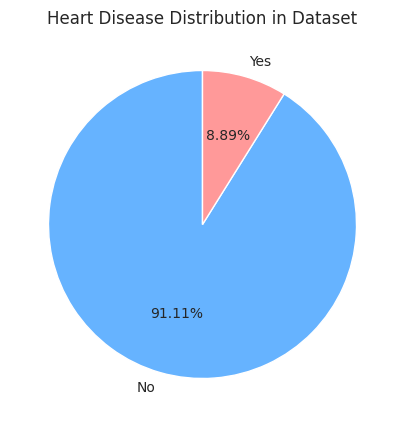

In [139]:
heart_disease_count = df["HeartDisease"].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(heart_disease_count.values, labels=heart_disease_count.index, autopct='%1.2f%%', colors=['#66b3ff', '#ff9999'], startangle=90)

plt.title("Heart Disease Distribution in Dataset")

plt.savefig("Heart_Disease_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()


Text(0.5, 1.0, 'Resampled Data Distribution (Over-sampling)')

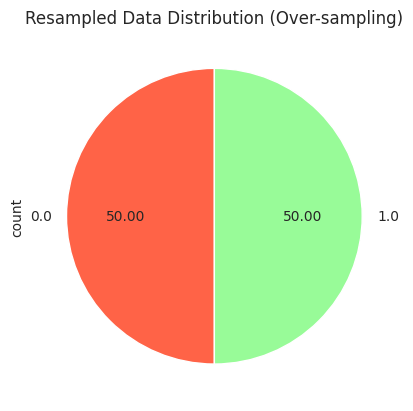

In [143]:
ros_resample = RandomOverSampler(sampling_strategy=1)
X_resampled, y_resampled = ros_resample.fit_resample(X, y)

ax = y_resampled.value_counts().plot.pie(autopct='%.2f', colors=['#ff6347', '#98fb98'], startangle=90)
ax.set_title("Resampled Data Distribution (Over-sampling)")

In [144]:
SEED = 42

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=SEED)



### - Train model (after resamling)

###  Logistic regression

In [147]:
log_reg_model = LogisticRegression(random_state=SEED)

hyperparameters = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}

stratified_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)

grid_search_log_reg = GridSearchCV(estimator=log_reg_model, param_grid=hyperparameters, scoring='roc_auc', cv=stratified_cv, n_jobs=-1)

grid_search_log_reg.fit(X_train_final, y_train_final)


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='roc_auc')

In [150]:
best_log_model = grid_search_log_reg.best_estimator_

pred_log_test = best_log_model.predict(X_test_final)
pred_log_train = best_log_model.predict(X_train_final)
pred_proba_log = best_log_model.predict_proba(X_test_final)[:, 1]

conf_matrix_log = confusion_matrix(y_test_final, pred_log_test)
class_report_log = classification_report(y_test_final, pred_log_test)

best_score_log = grid_search_log_reg.best_score_

accuracy_log_test = accuracy_score(y_test_final, pred_log_test)
accuracy_log_train = accuracy_score(y_train_final, pred_log_train)

rmse_log = mse(y_test_final, pred_log_test) ** 0.5

precision_log = precision_score(y_test_final, pred_log_test)
recall_log = recall_score(y_test_final, pred_log_test)
f1_log = f1_score(y_test_final, pred_log_test)

best_params_log = grid_search_log_reg.best_params_


In [151]:
print('Model: Logistic Regression (Post-Resampling)')
print("______________________________________________________________")
print('ROC AUC (Test): {:.3f} | Best CV ROC AUC (Train): {:.3f} | Accuracy (Test): {:.3f} | Accuracy (Train): {:.3f} | RMSE: {:.3f}'.format(
    auc(y_test_final, pred_proba_log), best_score_log, accuracy_log_test, accuracy_log_train, rmse_log))
print('Precision: {:.3f} | Recall: {:.3f} | F1-Score: {:.3f}'.format(
    precision_log, recall_log, f1_log))
print("______________________________________________________________")
print('Best Hyperparameters:', best_params_log)
print("_______________________________________________________________")
print('Confusion Matrix:\n', conf_matrix_log)
print("______________________________________________________________")
print('Classification Report:\n', class_report_log)


Model: Logistic Regression (Post-Resampling)
______________________________________________________________
ROC AUC (Test): 0.834 | Best CV ROC AUC (Train): 0.836 | Accuracy (Test): 0.757 | Accuracy (Train): 0.759 | RMSE: 0.493
Precision: 0.747 | Recall: 0.778 | F1-Score: 0.762
______________________________________________________________
Best Hyperparameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
_______________________________________________________________
Confusion Matrix:
 [[39799 14255]
 [11982 42071]]
______________________________________________________________
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.74      0.75     54054
         1.0       0.75      0.78      0.76     54053

    accuracy                           0.76    108107
   macro avg       0.76      0.76      0.76    108107
weighted avg       0.76      0.76      0.76    108107



### Random forest

In [154]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=SEED)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf_model = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

grid_search_rf_model.fit(X_train_final, y_train_final)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [155]:
best_rf_model = grid_search_rf_model.best_estimator_

pred_rf_test = best_rf_model.predict(X_test_final)
pred_rf_train = best_rf_model.predict(X_train_final)
pred_proba_rf = best_rf_model.predict_proba(X_test_final)[:, 1]

conf_matrix_rf = confusion_matrix(y_test_final, pred_rf_test)
class_report_rf = classification_report(y_test_final, pred_rf_test)

best_score_rf = grid_search_rf_model.best_score_

accuracy_rf_test = accuracy_score(y_test_final, pred_rf_test)
accuracy_rf_train = accuracy_score(y_train_final, pred_rf_train)

rmse_rf = mse(y_test_final, pred_rf_test) ** 0.5

precision_rf = precision_score(y_test_final, pred_rf_test)
recall_rf = recall_score(y_test_final, pred_rf_test)
f1_rf = f1_score(y_test_final, pred_rf_test)

best_params_rf = grid_search_rf_model.best_params_


In [156]:
print('Model: Random Forest Classifier (Post-Resampling)')
print("______________________________________________________________")
print('ROC AUC (Test): {:.3f} | Best CV ROC AUC (Train): {:.3f} | Accuracy (Test): {:.3f} | Accuracy (Train): {:.3f} | RMSE: {:.3f}'.format(
    auc(y_test_final, pred_proba_rf), best_score_rf, accuracy_rf_test, accuracy_rf_train, rmse_rf))
print('Precision: {:.3f} | Recall: {:.3f} | F1-Score: {:.3f}'.format(
    precision_rf, recall_rf, f1_rf))
print("______________________________________________________________")
print('Best Hyperparameters:', best_params_rf)
print("_______________________________________________________________")
print('Confusion Matrix:\n', conf_matrix_rf)
print("______________________________________________________________")
print('Classification Report:\n', class_report_rf)


Model: Random Forest Classifier (Post-Resampling)
______________________________________________________________
ROC AUC (Test): 0.845 | Best CV ROC AUC (Train): 0.847 | Accuracy (Test): 0.767 | Accuracy (Train): 0.770 | RMSE: 0.483
Precision: 0.741 | Recall: 0.821 | F1-Score: 0.779
______________________________________________________________
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
_______________________________________________________________
Confusion Matrix:
 [[38571 15483]
 [ 9691 44362]]
______________________________________________________________
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.71      0.75     54054
         1.0       0.74      0.82      0.78     54053

    accuracy                           0.77    108107
   macro avg       0.77      0.77      0.77    108107
weighted avg       0.77      0.77      0.77    1